In [76]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import yaml
from os.path import join
from hwtmode.data import load_patch_files, min_max_scale, storm_max_value, get_meta_scalars, combine_patch_data
import cartopy.crs as ccrs
import cartopy.feature as cfeature
%matplotlib inline

In [42]:
config_filename = "../config/ws_mode_cnn_train.yml"
with open(config_filename, "r") as config_file:
    config = yaml.load(config_file, Loader=yaml.Loader)

In [24]:

# Load training data
print(f"Loading training data period: {config['train_start_date']} to {config['train_end_date']}")
input = {}
output = {}
out_max = {}
labels = {}
meta = {}
meta_df = {}
input_combined = {}
input_scaled = {}
scale_values = {}
predictions = {}
modes = ["train", "val", "test"]
# Load training, validation, and testing data
for mode in modes:
    input[mode], output[mode], meta[mode] = load_patch_files(config[mode + "_start_date"],
                                                             config[mode + "_end_date"],
                                                             config["data_path"],
                                                             config["input_variables"],
                                                             config["output_variables"],
                                                             config["meta_variables"],
                                                             config["patch_radius"])
    input_combined[mode] = combine_patch_data(input[mode], config["input_variables"])
    if mode == "train":
        input_scaled[mode], scale_values[mode] = min_max_scale(input_combined[mode])
    else:
        input_scaled[mode], scale_values[mode] = min_max_scale(input_combined[mode], scale_values["train"])
    out_max[mode] = storm_max_value(output[mode][config["output_variables"][0]], meta[mode]["masks"])
    meta_df[mode] = get_meta_scalars(meta[mode])
    print(meta_df[mode].columns)
    if config["classifier"]:
        labels[mode] = np.where(out_max[mode] >= config["classifier_threshold"], 1, 0)
    else:
        labels[mode] = out_max[mode]

Loading training data period: 2010-10-01 to 2014-12-31


100%|█████████████████████| 317/317 [05:04<00:00,  1.04it/s]


REFL_1KM_AGL_curr
U10_curr
V10_curr


  0%|                                | 0/73 [00:00<?, ?it/s]

['time', 'centroid_lon', 'centroid_lat', 'centroid_i', 'centroid_j', 'track_id', 'track_step', 'run_date']
Index(['time', 'centroid_lon', 'centroid_lat', 'centroid_i', 'centroid_j',
       'track_id', 'track_step', 'run_date'],
      dtype='object')


100%|███████████████████████| 73/73 [01:18<00:00,  1.07s/it]


REFL_1KM_AGL_curr
U10_curr
V10_curr


  0%|                               | 0/180 [00:00<?, ?it/s]

['time', 'centroid_lon', 'centroid_lat', 'centroid_i', 'centroid_j', 'track_id', 'track_step', 'run_date']
Index(['time', 'centroid_lon', 'centroid_lat', 'centroid_i', 'centroid_j',
       'track_id', 'track_step', 'run_date'],
      dtype='object')


100%|█████████████████████| 180/180 [03:05<00:00,  1.03s/it]


REFL_1KM_AGL_curr
U10_curr
V10_curr
['time', 'centroid_lon', 'centroid_lat', 'centroid_i', 'centroid_j', 'track_id', 'track_step', 'run_date']
Index(['time', 'centroid_lon', 'centroid_lat', 'centroid_i', 'centroid_j',
       'track_id', 'track_step', 'run_date'],
      dtype='object')


In [151]:
saliency_nc_file = "/glade/work/dgagne/mode_cnn_20200421/neuron_saliency_cnn_20200421_001_val.nc"
sal_ds = xr.open_dataarray(saliency_nc_file)

In [26]:
input["val"]

<xarray.Dataset>
Dimensions:            (col: 33, p: 62865, row: 33)
Coordinates:
  * col                (col) int32 24 25 26 27 28 29 30 ... 50 51 52 53 54 55 56
  * row                (row) int32 24 25 26 27 28 29 30 ... 50 51 52 53 54 55 56
  * p                  (p) int64 0 1 2 3 4 5 ... 62860 62861 62862 62863 62864
Data variables:
    REFL_1KM_AGL_curr  (p, row, col) float32 -32.16125 -17.883072 ... 18.350441
    U10_curr           (p, row, col) float32 7.4909678 7.1230865 ... -2.4446685
    V10_curr           (p, row, col) float32 8.080585 8.206953 ... -0.49967128
Attributes:
    Conventions:             CF-1.6
    title:                   NCARSTORM Storm Patches for run 20140111-0000 me...
    object_variable:         REFL_COM
    start_hour:              12
    end_hour:                35
    watershed_variable:      REFL_COM
    ensemble_name:           NCARSTORM
    ensemble_members:        ['d01']
    model_path:              /glade/p/mmm/parc/sobash/NSC/3KM_WRF_POST_12sec_ts/
    segmentation_approach:   ws
    model_watershed_params:  (35, 50)
    size_filter:             12
    gaussian_window:         1
    mrms_path:               None
    mrms_variable:           MESH_Max_60min_00.50
    mrms_watershed_params:   (13, 1, 125, 100, 100)
    object_matcher_params:   ([<function shifted_centroid_distance at 0x2b026...
    track_matcher_params:    ([<function centroid_distance at 0x2b026d7c2950>...
    shape_variables:         ['area', 'eccentricity', 'major_axis_length', 'm...
    variable_statistics:     ['mean', 'max', 'min']
    csv_path:                /glade/scratch/ahijevyc/track_data_ncarstorm_3km...
    geojson_path:            /glade/scratch/ahijevyc/track_data_ncarstorm_3km...
    nc_path:                 /glade/scratch/ahijevyc/track_data_ncarstorm_3km...
    patch_radius:            40
    unique_matches:          True
    closest_matches:         True
    match_steps:             True
    train:                   False
    single_step:             True
    label_type:              gamma
    model_map_file:          /glade/u/home/sobash/hagelslag/mapfiles/ncar_sto...
    mask_file:               /glade/u/home/sobash/hagelslag/mapfiles/ncar_sto...
    json:                    False
    run_date_format:         %Y%m%d-%H%M

/glade/u/home/dgagne/miniconda3/envs/goes/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: No contour levels were found within the data range.
  


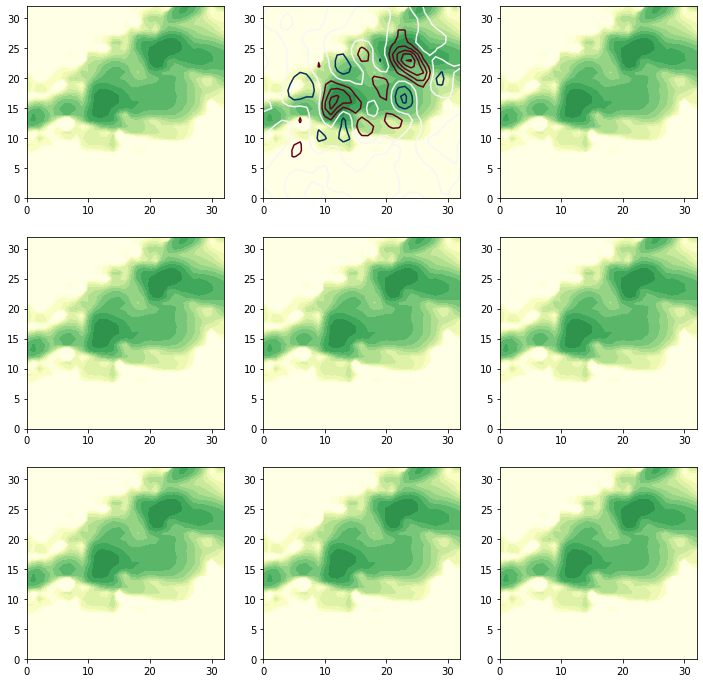

In [160]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
idx = 25832
for a, ax in enumerate(axes.ravel()):
    gf = gaussian_filter(sal_ds[a, idx, :, :, 0], 1)
    ax.contourf(input_combined["val"][idx, :, :, 0], np.arange(0, 80, 5), cmap="YlGn", extend="both")
    ax.contour(-gf, vmin=-2, vmax=2, cmap="RdBu_r")


In [36]:
out_max["val"].argmax()

49464

In [112]:
neuron_activations = pd.read_csv(join(config["out_path"], "neuron_activations_cnn_20200421_001_val.csv"))

In [114]:
neuron_scores = pd.read_csv(join(config["out_path"], "neuron_scores_cnn_20200421_001.csv"))

In [115]:
neuron_scores

,mode,neuron_000,neuron_001,neuron_002,neuron_003,neuron_004,neuron_005,neuron_006,neuron_007,neuron_008
0,train,0.5,0.841579,0.5,0.501716,0.100738,0.5,0.147303,0.133913,0.5
1,val,0.5,0.843169,0.5,0.503295,0.098174,0.5,0.144951,0.129098,0.5
2,test,0.5,0.777695,0.5,0.501183,0.161610,0.5,0.271913,0.188667,0.5


In [52]:
neuron_activations.groupby("run_date").count().iloc[32]

index           1626
time            1626
centroid_lon    1626
centroid_lat    1626
centroid_i      1626
centroid_j      1626
track_id        1626
track_step      1626
neuron_000      1626
neuron_001      1626
neuron_002      1626
neuron_003      1626
neuron_004      1626
neuron_005      1626
neuron_006      1626
neuron_007      1626
neuron_008      1626
neuron_009      1626
neuron_010      1626
neuron_011      1626
neuron_012      1626
neuron_013      1626
neuron_014      1626
neuron_015      1626
Name: 2014-05-27 00:00:00, dtype: int64

In [136]:
neuron_activations["run_date"].unique()

array(['2014-01-11 00:00:00', '2014-02-20 00:00:00',
       '2014-02-21 00:00:00', '2014-03-16 00:00:00',
       '2014-03-26 00:00:00', '2014-03-27 00:00:00',
       '2014-03-28 00:00:00', '2014-04-02 00:00:00',
       '2014-04-03 00:00:00', '2014-04-04 00:00:00',
       '2014-04-06 00:00:00', '2014-04-07 00:00:00',
       '2014-04-12 00:00:00', '2014-04-13 00:00:00',
       '2014-04-14 00:00:00', '2014-04-24 00:00:00',
       '2014-04-25 00:00:00', '2014-04-27 00:00:00',
       '2014-04-28 00:00:00', '2014-04-29 00:00:00',
       '2014-05-07 00:00:00', '2014-05-08 00:00:00',
       '2014-05-09 00:00:00', '2014-05-10 00:00:00',
       '2014-05-11 00:00:00', '2014-05-13 00:00:00',
       '2014-05-14 00:00:00', '2014-05-20 00:00:00',
       '2014-05-21 00:00:00', '2014-05-22 00:00:00',
       '2014-05-25 00:00:00', '2014-05-26 00:00:00',
       '2014-05-27 00:00:00', '2014-05-30 00:00:00',
       '2014-06-01 00:00:00', '2014-06-03 00:00:00',
       '2014-06-04 00:00:00', '2014-06-05 00:0

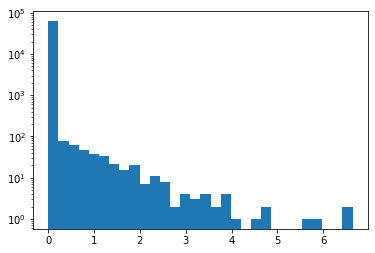

In [148]:
plt.hist(neuron_activations["neuron_003"], bins=30)
plt.gca().set_yscale("log")

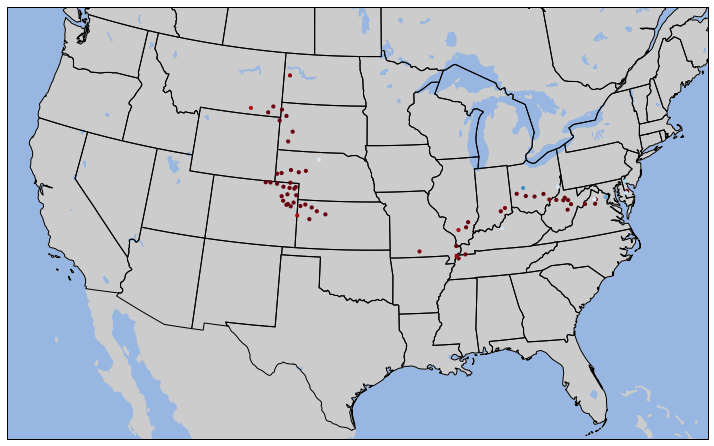

In [161]:
fig = plt.figure(figsize=(10, 6))
crs = ccrs.PlateCarree()
ax = fig.add_axes([0, 1, 1, 1], projection=ccrs.LambertConformal())
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor="0.8")
ocean_50m = cfeature.NaturalEarthFeature('physical', 'ocean', '50m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS["water"])
states_50m = cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces', "50m",
                                          edgecolor="k", facecolor="none")
lakes_50m = cfeature.NaturalEarthFeature("physical", "lakes", "50m", edgecolor="face",
                                         facecolor=cfeature.COLORS["water"])
ax.add_feature(ocean_50m, zorder=1)
ax.add_feature(land_50m, zorder=2)
ax.add_feature(lakes_50m, zorder=2)
ax.add_feature(states_50m, zorder=3)
run_date = "2014-06-04 00:00:00"
n1_idx = (neuron_activations["run_date"] == run_date) & (neuron_activations["neuron_001"] > 5)
n3_idx = (neuron_activations["run_date"] == run_date) & (neuron_activations["neuron_003"] > 0.5)

n1_examples = np.where(n1_idx == True)[0]
ax.scatter(neuron_activations.loc[n1_idx, "centroid_lon"], 
            neuron_activations.loc[n1_idx, "centroid_lat"],
            10, neuron_activations.loc[n1_idx, "neuron_001"], vmin=0, vmax=6, cmap="Reds", transform=crs, zorder=4)
ax.scatter(neuron_activations.loc[n3_idx, "centroid_lon"], 
            neuron_activations.loc[n3_idx, "centroid_lat"],
            10, neuron_activations.loc[n3_idx, "neuron_003"], vmin=0, vmax=6, cmap="Blues", transform=crs, zorder=4)
ax.set_extent((-120, -74, 23, 50))

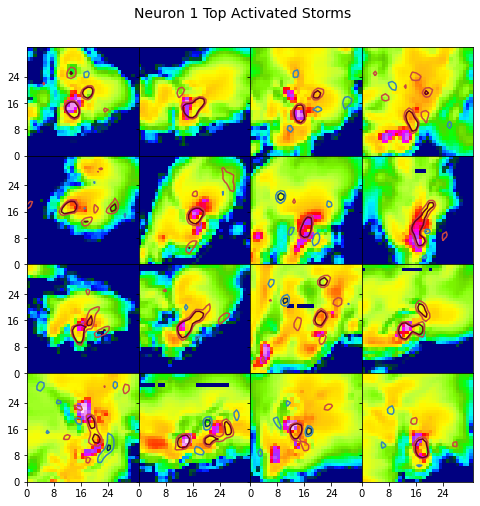

In [185]:
n_rank = neuron_activations["neuron_001"].argsort()[::-1].values
fig, axes = plt.subplots(4, 4, figsize=(8, 8), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0, hspace=0)
for a, ax in enumerate(axes.ravel()):
    ax.pcolormesh(input_combined["val"][n_rank[a], :, :, 0], cmap="gist_ncar", vmin=0, vmax=80)
    gf = gaussian_filter(sal_ds[1, n_rank[a], :, :, 0], 1)
    ax.contour(gf / gf.std(), [-3, -2, 2, 3], vmin=-3, vmax=3, cmap="RdBu_r")    
    ax.set_xticks(np.arange(0, 32, 8))
    ax.set_yticks(np.arange(0, 32, 8))
fig.suptitle("Neuron 1 Top Activated Storms", fontsize=14, y=0.95)
plt.savefig("cnn_001_neuron_001.png", dpi=200, bbox_inches="tight")

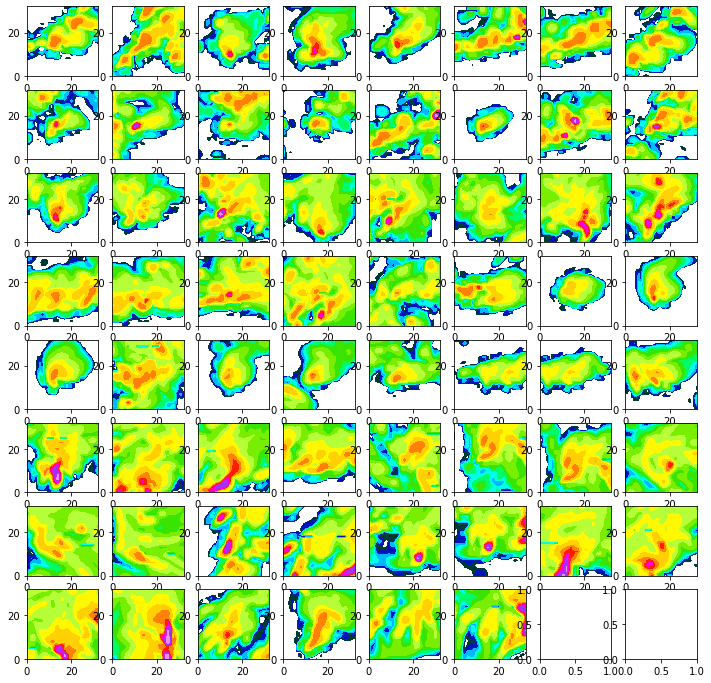

In [165]:
fig, axes = plt.subplots(8 , 8, figsize=(12, 12))
for a, ax in enumerate(axes.ravel()):
    if a < n1_examples.size:
        ax.contourf(input_combined["val"][n1_examples[a], :, :, 0], np.arange(0, 80, 5), cmap="gist_ncar", vmin=0, vmax=80)

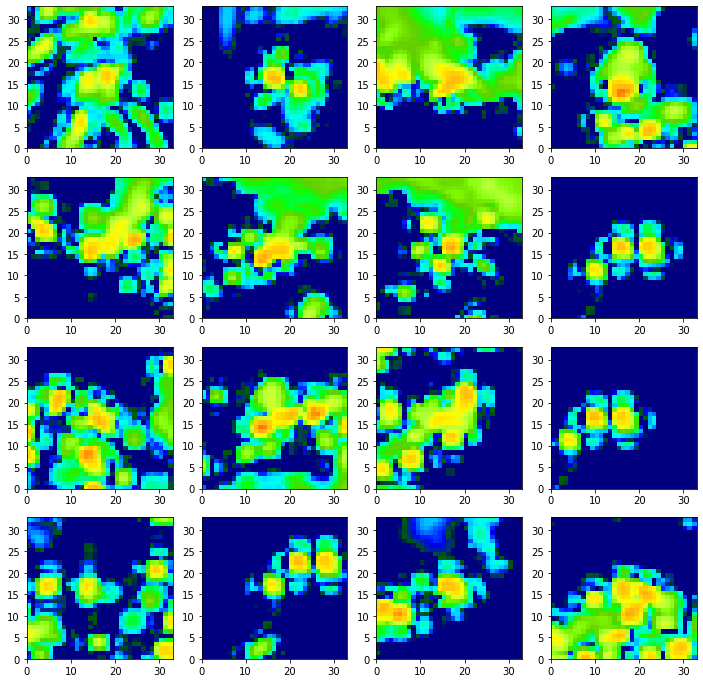

In [127]:
n_rank = neuron_activations["neuron_008"].argsort()[::-1].values
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
for a, ax in enumerate(axes.ravel()):
    ax.pcolormesh(input_combined["val"][n_rank[a], :, :, 0], cmap="gist_ncar", vmin=0, vmax=80)